In [1]:
import json
from typing import TypedDict, List, Optional, Union, Literal
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState


In [2]:
class TextContent(TypedDict):
    type: str
    text: str
    inline_css: Optional[str]


class ImageContent(TypedDict):
    type: str
    src: str
    alt: Optional[str]
    inline_css: Optional[str]


class LinkContent(TypedDict):
    type: str
    text: str
    url: str
    inline_css: Optional[str]


class ButtonContent(TypedDict):
    type: str
    text: str
    url: str
    inline_css: Optional[str]


class SectionContent(TypedDict):
    type: str
    content: List[
        Union["SectionContent", TextContent, ImageContent, LinkContent, ButtonContent]
    ]
    inline_css: Optional[str]


class HeaderContent(TypedDict):
    logo: str
    navigation: List[LinkContent]
    css: Optional[str]


class FooterContent(TypedDict):
    text: str
    links: List[LinkContent]
    css: Optional[str]


class ArticleContent(TypedDict):
    type: str
    title: str
    author: str
    body: List[Union[TextContent, ImageContent, LinkContent, SectionContent]]
    published_date: Optional[str]
    tags: Optional[List[str]]
    css: Optional[str]


class MetaData(TypedDict):
    title: str
    description: str
    keywords: List[str]
    author: Optional[str]
    viewport: str


class Component(TypedDict):
    type: str
    db_ref: str
    content: Union[HeaderContent, FooterContent, SectionContent, ArticleContent]
    css: Optional[str]


class Website(TypedDict):
    name: str
    url: str
    metadata: MetaData
    components: List[Component]


class Data(TypedDict):
    user_prompt: str
    website: Website

In [3]:
model = ChatOpenAI(
    # model="gpt-4o",
    model="gpt-4o-mini",
    temperature=1,
)

In [4]:
def draft(state: MessagesState):
    prompt = ChatPromptTemplate.from_template(
        """
    You are an innovative web designer tasked with creating a series random websites, each with a unique and diverse style.
    For each website, you should provide a user prompt which corresponds to the design brief for that site from the user.
    The user prompt must be in natural language, not too technical or formal, and it must focus on styling, colors, layout, and overall aesthetic more than technical details.
    For images,always use this placeholder: https://placehold.co/[width]x[height]/png
    Your goal is to explore a wide range of design aesthetics, from minimalist to maximalist, from vintage to futuristic. Each website should have a distinct theme, color palette, typography, and layout.
    Think of these websites as being created for different fictional businesses, blogs, portfolios, or personal pages. Some might be clean and simple with lots of white space, while others could be bold and colorful, full of dynamic elements. Your designs should vary in tone and purpose, capturing the essence of different industries, personalities, and target audiences."""
    )
    chain = {} | prompt | model.with_structured_output(Data)
    response = chain.invoke(state["messages"])
    return {"messages": [AIMessage(content=json.dumps(response))]}

In [5]:
def revise(state: MessagesState):
    prompt = ChatPromptTemplate.from_template(
        """
    You are a masterful web design critic and enhancer, tasked with refining and improving a series of diverse website designs generated by another AI assistant.
    Your role is to iterate over each design, reflecting critically on its aesthetic choices, usability, and alignment with its intended theme. Consider the target audience, the purpose of the website, and the effectiveness of the design elements used. Enhance the original designs by:

    - Improving the layout for better visual flow and user experience.
    - Fine-tuning the color palette to achieve greater harmony or contrast as needed.
    - Optimizing typography for readability and stylistic coherence.
    - Introducing or refining interactive elements to elevate user engagement.

    - Ensuring the design is responsive and accessible across different devices and screen sizes.
    Your goal is to take the original concept and push it to its full potential, making each website not just visually appealing but also - - - functionally superior. Reflect on what each design is trying to achieve, identify areas for improvement, and meticulously enhance them, - - delivering a polished and optimized final product.

    here's the website you need to revise:
    {data}
    """
    ).partial(data=state["messages"][-1])
    chain = {} | prompt | model.with_structured_output(Data)
    response = chain.invoke(state["messages"])
    return {"messages": [AIMessage(content=json.dumps(response))]}

In [6]:
MAX_ITERATIONS = 1


def _get_num_iterations(state: list) -> int:
    i = 0
    for m in state["messages"][::-1]:
        if m.type not in {"ai"}:
            break
        i += 1
    return i


def event_loop(state: list) -> Literal["revise", "__end__"]:
    num_iterations = _get_num_iterations(state)
    return END if num_iterations > MAX_ITERATIONS else "revise"

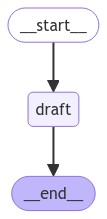

In [7]:
from IPython.display import Image, display

workflow = StateGraph(MessagesState)
workflow.add_node("draft", draft)
# workflow.add_node("revise", revise)

workflow.add_edge(START, "draft")  # start -> draft
workflow.add_edge("draft", END)  # draft -> end
# workflow.add_edge("draft", "revise")  # draft -> revise
# workflow.add_edge("revise", END)  # revise -> end
# workflow.add_conditional_edges("revise", event_loop)  # revise -> end | revise
checkpointer = MemorySaver()
app = workflow.compile(checkpointer=checkpointer, debug=True)
display(Image(app.get_graph().draw_mermaid_png()))

In [13]:
SAMPLE_SIZE = 2

for i in range(SAMPLE_SIZE):
    print(f"Generating website {i+1}")
    with open("website.jsonl", "a+") as f:
        checkpointer = MemorySaver()
        app = workflow.compile(checkpointer=checkpointer, debug=True)
        output = app.invoke(
            {"messages": [HumanMessage(content="generate a website schema")]},
            config={"configurable": {"thread_id": 42}},
        )
        data = Data(**json.loads(output["messages"][-1].content))
        f.write(
            json.dumps(
                {
                    "messages": [
                        {"role": "user", "content": data["user_prompt"]},
                        {"role": "assistant", "content": json.dumps(data["website"])},
                    ]
                }
            )
            + "\n"
        )

Generating website 1
[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'messages': [HumanMessage(content='generate a website schema')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [HumanMessage(content='generate a website schema')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='generate a website schema', id='10eb0506-0a53-40b4-8fb1-5e40ea919012')]}
[1:tasks] Starting step 1 with 1 task:
- draft -> {'messages': [HumanMessage(content='generate a website schema', id='10eb0506-0a53-40b4-8fb1-5e40ea919012')]}
[1:writes] Finished step 1 with writes to 1 channel:
- messages -> [AIMessage(content='{"user_prompt": "I\'m looking for a vibrant and quirky website for my vintage toy store. I want bold, playful colors like bright reds, yellows, and blues. The layout should be fun and slightly chaotic, with lots of images of toys scattered creatively on the page. Incorporate retr

In [39]:
def render_inline_css(css: Optional[str]) -> str:
    return f' style="{css}"' if css else ""


def render_text_content(content: TextContent) -> str:
    return f'<p{render_inline_css(content.get("inline_css"))}>{content["text"]}</p>'


def render_image_content(content: ImageContent) -> str:
    return f'<img src="{content["src"]}" alt="{content.get("alt", "")}"{render_inline_css(content.get("inline_css"))}/>'


def render_link_content(content: LinkContent) -> str:
    return f'<a href="{content["url"]}"{render_inline_css(content.get("inline_css"))}>{content["text"]}</a>'


def render_button_content(content: ButtonContent) -> str:
    return f'<a href="{content["url"]}" class="button"{render_inline_css(content.get("inline_css"))}>{content["text"]}</a>'


def render_section_content(content: SectionContent) -> str:
    inner_html = "".join(render_content(item) for item in content["content"])
    return f'<div{render_inline_css(content.get("inline_css"))}>{inner_html}</div>'


def render_header_content(content: HeaderContent) -> str:
    nav_items = "".join(render_link_content(link) for link in content["navigation"])
    return f'<header{render_inline_css(content.get("css"))}><img src="{content["logo"]}" alt="Logo"/><nav>{nav_items}</nav></header>'


def render_footer_content(content: FooterContent) -> str:
    link_items = "".join(render_link_content(link) for link in content["links"])
    return f'<footer{render_inline_css(content.get("css"))}><p>{content["text"]}</p><nav>{link_items}</nav></footer>'


def render_article_content(content: ArticleContent) -> str:
    body_html = "".join(render_content(item) for item in content["body"])
    tags_html = "".join(
        f'<span class="tag">{tag}</span>' for tag in content.get("tags", [])
    )
    return f"""
    <article{render_inline_css(content.get("css"))}>
        <h1>{content["title"]}</h1>
        <p class="author">By {content["author"]}</p>
        <div class="body">{body_html}</div>
        <div class="tags">{tags_html}</div>
    </article>
    """


def render_content(
    content: Union[
        TextContent, ImageContent, LinkContent, ButtonContent, SectionContent
    ]
) -> str:
    content_type = content["type"]
    if content_type == "text":
        return render_text_content(content)
    elif content_type == "image":
        return render_image_content(content)
    elif content_type == "link":
        return render_link_content(content)
    elif content_type == "button":
        return render_button_content(content)
    elif content_type == "section":
        return render_section_content(content)


def render_component(component: Component) -> str:
    component_type = component["type"]
    if "header" in component_type.lower():
        return render_header_content(component["content"])
    elif "footer" in component_type.lower():
        return render_footer_content(component["content"])
    elif "section" in component_type.lower():
        return render_section_content(component["content"])
    elif "article" in component_type.lower():
        return render_article_content(component["content"])
    else:
        # If the component type is not recognized, return an empty string
        return ""


def render_website(website: Website) -> str:
    metadata = website["metadata"]
    components_html = "".join(
        render_component(component) for component in website["components"] if component
    )

    return f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="{metadata["viewport"]}">
        <meta name="description" content="{metadata["description"]}">
        <meta name="keywords" content="{', '.join(metadata["keywords"])}">
        <title>{metadata["title"]}</title>
    </head>
    <body>
        {components_html}
    </body>
    </html>
    """

In [40]:
from IPython.core.display import HTML

with open("website.jsonl", "r") as f:
    all_lines = f.readlines()
    data = json.loads(all_lines[-1])
    website = json.loads(data["messages"][1]["content"])

w = render_website(website)

print(w)

HTML(w)

TypeError: sequence item 0: expected str instance, NoneType found